In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils
import torch
from torch import optim
import torch.nn.functional as F

In [2]:
# import imgshow and plot show
#impot class SiameseNetworkDataset 
from utils.plot_helpers import imshow, show_plot
from utils.siamese_dataset import SiameseNetworkDataset
import os

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
# Load the training dataset
transformation = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                     transforms.RandomHorizontalFlip()
                                    ])

folder_datatrain = SiameseNetworkDataset(root_path=os.path.join('dataset_jpg1','train'), transform=transformation)

train_size = int(0.8 * len(folder_datatrain))
val_size = len(folder_datatrain) - train_size

siamese_datatrain, siamese_dataval = torch.utils.data.random_split(folder_datatrain, [train_size, val_size])


# Create a simple dataloader just for simple visualization-train
vis_datatrain = DataLoader(siamese_datatrain,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)

# Create a simple dataloader just for simple visualization-val
vis_dataval = DataLoader(siamese_dataval,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)

In [5]:
tmp = next(iter(siamese_datatrain))
len(tmp), tmp[0].shape, tmp[1].shape, tmp[2].shape

(3, torch.Size([3, 224, 224]), torch.Size([3, 224, 224]), torch.Size([1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


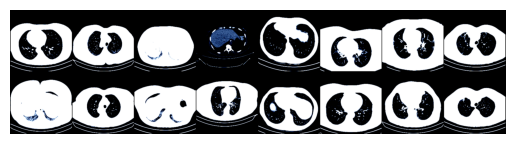

[1. 1. 0. 1. 1. 1. 1. 0.]


In [6]:
# Extract one batch

example_batchv = next(iter(vis_dataval))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same class of image, label is 0, same classe of image in both
concatenated = torch.cat((example_batchv[0], example_batchv[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batchv[2].numpy().reshape(-1))

In [7]:
np.unique(example_batchv[0][0])

array([-1.4500387 , -1.4329139 , -1.4157891 , -1.3986644 , -1.3815396 ,
       -1.3644148 , -1.352941  , -1.3472902 , -1.3354341 , -1.3301654 ,
       -1.317927  , -1.3130406 , -1.30042   , -1.2959158 , -1.2829131 ,
       -1.2787911 , -1.265406  , -1.2616663 , -1.247899  , -1.2445416 ,
       -1.230392  , -1.2274169 , -1.212885  , -1.2102921 , -1.1953781 ,
       -1.1931673 , -1.177871  , -1.1760426 , -1.160364  , -1.1589178 ,
       -1.1428571 , -1.141793  , -1.12535   , -1.1247058 , -1.1246684 ,
       -1.107843  , -1.1075436 , -1.1072767 , -1.0904187 , -1.0903361 ,
       -1.0898474 , -1.073294  , -1.0728291 , -1.0724182 , -1.0561693 ,
       -1.055322  , -1.0549891 , -1.0390445 , -1.0378151 , -1.0375599 ,
       -1.0219197 , -1.0203081 , -1.0201306 , -1.004795  , -1.0028011 ,
       -1.0027015 , -0.9876702 , -0.9852941 , -0.9852723 , -0.9705454 ,
       -0.9678431 , -0.9677871 , -0.95342064, -0.9504139 , -0.9502801 ,
       -0.9362959 , -0.9329847 , -0.93277305, -0.91917115, -0.91

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


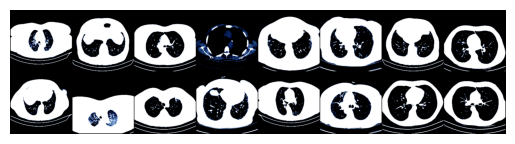

[1. 1. 1. 0. 1. 0. 1. 1.]


In [8]:
# Extract one batch
example_batcht = next(iter(vis_datatrain))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batcht[0], example_batcht[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batcht[2].numpy().reshape(-1))

In [9]:
from utils.siamese_network import SiameseNetwork, ContrastiveLoss

In [10]:
tmp=SiameseNetwork()
print(tmp.Vgg11)

d:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

<img src="images/loss_fnc.png" width="500" align="center"/>

In [11]:
# Load the training dataset
train_dataloader = DataLoader(siamese_datatrain,
                        shuffle=True,
                        num_workers=0, #8
                        batch_size=64)
# Load the validation dataset
val_dataloader = DataLoader(siamese_dataval,
                        shuffle=True,
                        num_workers=0, #8
                        batch_size=64)

dataloaders={'train': train_dataloader,
              'val': val_dataloader}

In [12]:
#net = SiameseNetwork().cuda()
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

<img src="images/siameses_example.PNG" width="600" align="center"/>

In [13]:
# Train the model
model,metrics =net.train_eval(net,optimizer,
                              criterion,
                              dataloaders,
                              num_epochs = 5)

Epoch 1/5
----------
Epoch number 1/5
Loss: 1.459 Acc: 0.422 
Epoch number 1/5
Loss: 1.238 Acc: 0.438 
Epoch 2/5
----------
Epoch number 2/5
Loss: 1.046 Acc: 0.578 
Epoch number 2/5
Loss: 1.379 Acc: 0.547 
Epoch 3/5
----------
Epoch number 3/5
Loss: 1.193 Acc: 0.391 
Epoch number 3/5
Loss: 1.388 Acc: 0.484 
Epoch 4/5
----------
Epoch number 4/5
Loss: 1.108 Acc: 0.531 
Epoch number 4/5
Loss: 1.345 Acc: 0.469 
Epoch 5/5
----------
Epoch number 5/5
Loss: 1.136 Acc: 0.500 
Epoch number 5/5
Loss: 1.166 Acc: 0.688 


In [16]:
print(f"The model is in: {next(model.parameters()).device}")

The model is in: cuda:0


In [20]:
acc = []
for i, data in enumerate(metrics["acc"]):
    acc.append(data.cpu().numpy())


In [21]:
def show_plot(iteration,loss, name:str, figsize=(5,3)):
    plt.figure(figsize=figsize)
    plt.plot(iteration,loss)
    plt.title(f"{name} at epoch {len(iteration)}")
    plt.show()


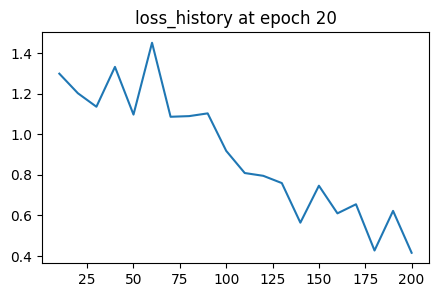

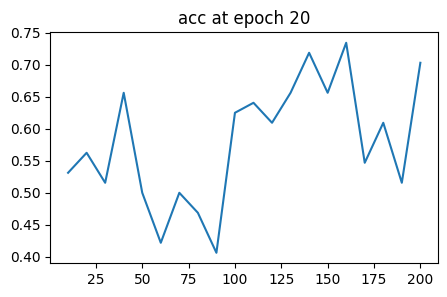

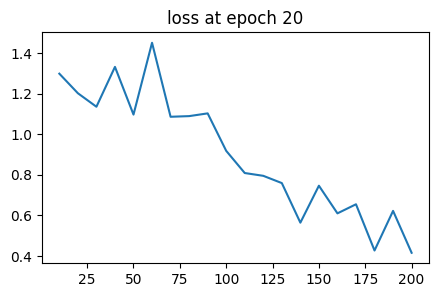

In [22]:
show_plot(metrics["counter"], metrics["loss_history"], "loss_history")
show_plot(metrics["counter"], acc, "acc")
show_plot(metrics["counter"], metrics["loss"], "loss")
# print('counter =',metrics["counter"])
# print('loss_history =',metrics["loss_history"])
# print('loss =',metrics["loss"])

## Save Trained Model

In [39]:
model_path = 'trainded_models/model_vgg11.pth'
torch.save(model.state_dict(),model_path)

In [27]:
model_path = 'trainded_models/model_vgg11.pth'
model = SiameseNetwork()
model.load_state_dict(torch.load(model_path))
model.eval().to(device)

d:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SiameseNetwork(
  (Vgg11): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(kerne

In [28]:
print(next(model.parameters()).device)

cuda:0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


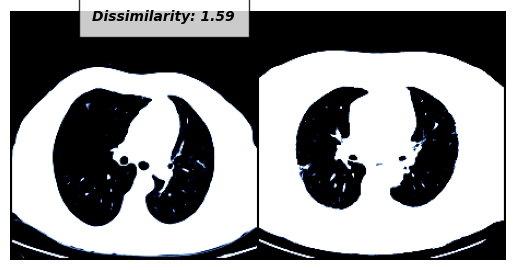

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


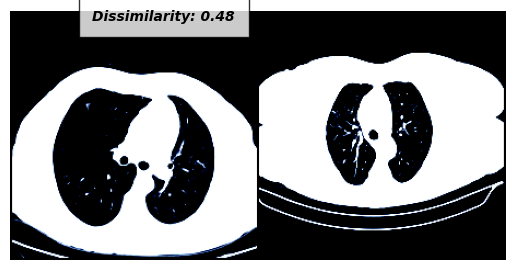

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


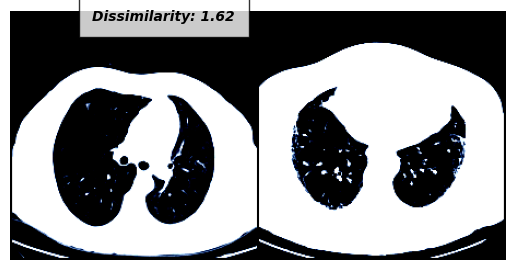

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


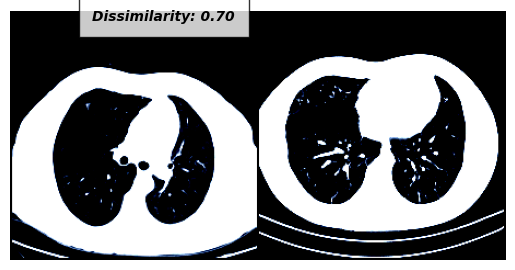

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


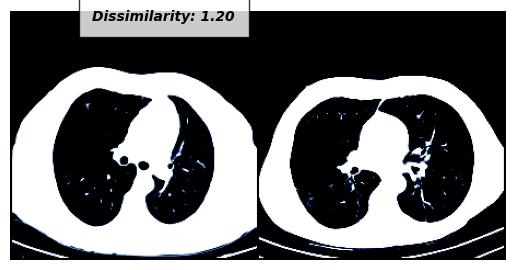

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


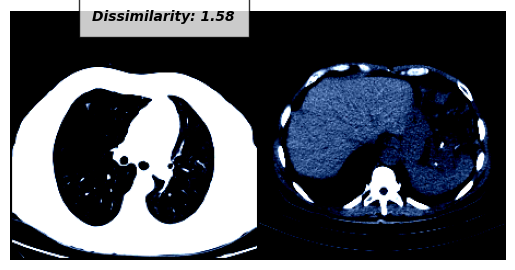

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


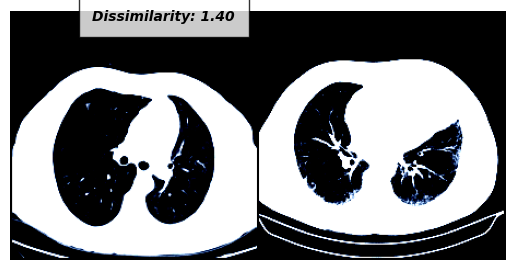

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


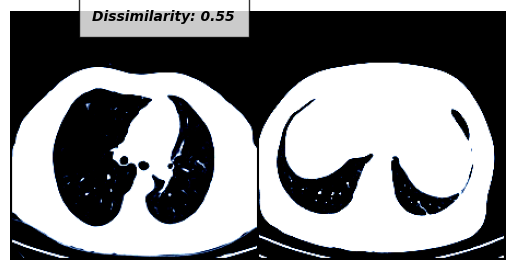

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


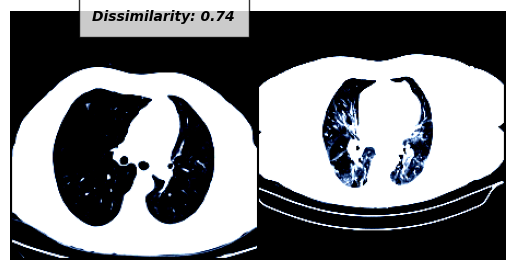

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


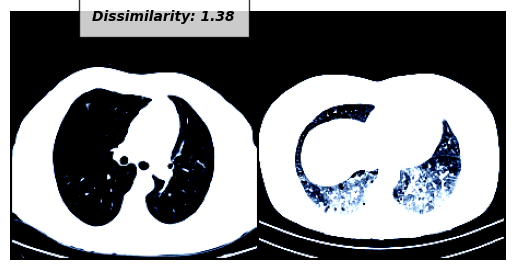

In [31]:
# Locate the test dataset and load it into the SiameseNetworkDataset
test_transformation = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                     ])

folder_test = SiameseNetworkDataset(root_path=os.path.join('dataset_jpg1','test'), transform=test_transformation)


test_dataloader = DataLoader(folder_test, num_workers=0, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)

# First image
x0, _, _ = next(dataiter)
x0 = x0.to(device)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)
    x1 = x1.to(device)
    
    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = model(x0, x1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

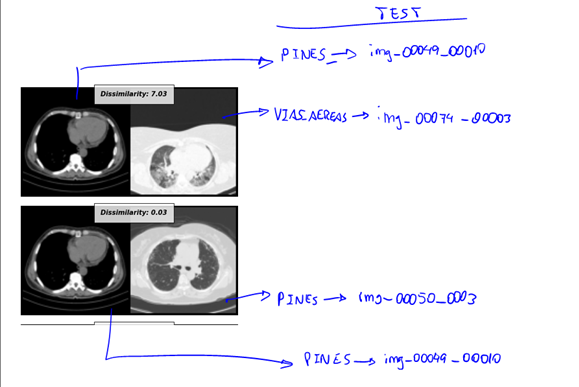

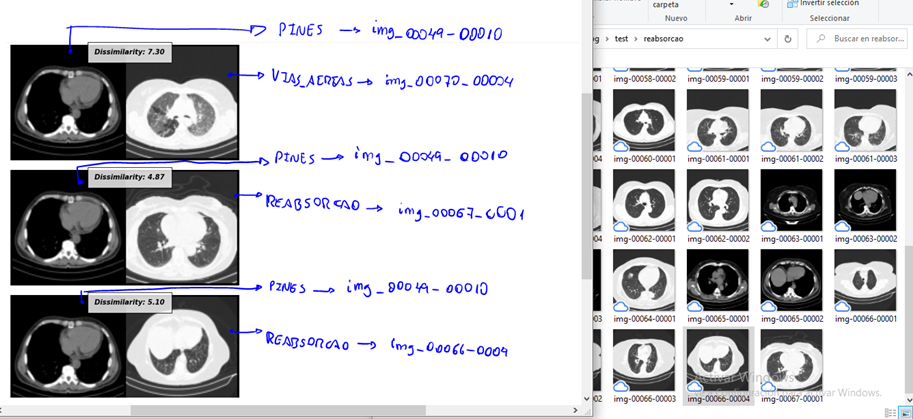

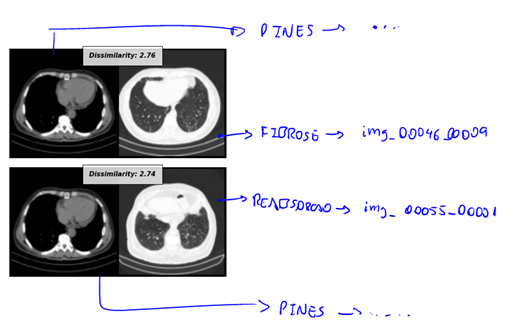